In [13]:
import os
import warnings

import pandas as pd
import numpy as np


from jre_utils.datapath import (
    DATA_DIRECTORY_PATH,
)
from jre_utils.config import asset_types

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [14]:
def area_to_int(area):
    if area == "2,000 m^2 or greater.":
        return 2000
    elif area == "5000 m^2 or greater.":
        return 5000
    else:
        return int(area)


def map_time_units(x):
    mapping = {
        "30-60minutes": 45,
        "1H-1H30": 75,
        "1H30-2H": 105,
        "2H-": 135,
    }

    return int(x) if x.isdigit() else mapping[x]


def map_layout(x):
    if x == "na":
        return "na"

    x = x.split("+")[0]

    if x[0].isdigit() and int(x[0]) == 1:
        if x != "1K" and x != "1LDK" and x != "1DK":
            return "1other"
        return x

    if x[0].isdigit() and int(x[0]) == 2:
        if x != "2LDK" and x != "2DK":
            return "2other"
        return x

    if x[0].isdigit() and int(x[0]) > 2:
        return f"{min(int(x[0]), 5)}LDK"

    return "other"


def map_land_shape(x):
    x = x.lower()
    x = x.replace("semi-", "")
    return x


def map_frontage(x):
    x = str(x)
    if x == "na":
        return 0
    if x == "50.0m or longer.":
        return 55
    return int(x.split(".")[0])


def map_floor_area(x):
    x = str(x)
    if "less" in x:
        return 10
    elif "greater" in x:
        return 2000
    else:
        return int(x.split(".")[0])


def map_year_of_construction(x):
    if x == "before the war":
        return 1930

    return int(x)

In [15]:
import json
from pprint import pprint

sub_city_to_city_path = f"{DATA_DIRECTORY_PATH}/core_scraped/sub_city_to_city.json"
with open(sub_city_to_city_path) as fd:
    sub_city_to_city = json.load(fd)
    pprint(f"E.g. Maps 1101 to {sub_city_to_city['1101']}")

area_code_to_area_path = f"{DATA_DIRECTORY_PATH}/core_scraped/area_code_to_area.json"
with open(area_code_to_area_path) as fd:
    area_code_to_area = json.load(fd)
    pprint(f"E.g. Maps 1100 to {area_code_to_area['1100']}")


def get_city_code(area_code):
    return sub_city_to_city.get(area_code, area_code)


def get_area_from_area_code(area_code):
    return area_code_to_area.get(area_code, "na")


subarea_coords_simple_path = f"{DATA_DIRECTORY_PATH}/coordinates/subarea_simple.csv"
coordinates_df = pd.read_csv(subarea_coords_simple_path)
coordinates_df["area_code"] = coordinates_df["area_code"].astype(str)

'E.g. Maps 1101 to 1100'
'E.g. Maps 1100 to Hokkaido Sapporo-shi'


In [16]:
def is_contiguous(arr):
    sorted_arr = sorted(arr)
    return all((y2 - y1) == 1 for y1, y2 in zip(sorted_arr, sorted_arr[1:]))

def is_up_to_date(years, end_year):
    return max(years) == end_year

def is_valid_area_df(years_count_dict, end_year):
    years = [int(year) for year, count in years_count_dict.items() if count > 3]
    return len(years) > 8 and is_contiguous(years) and is_up_to_date(years, end_year)


In [17]:
def process_transactions_df(df):
    df["area_code"] = df["City,Town,Ward,Village code"].astype(str)

    # we may want to skip the following step in the future
    df["area_code"] = df["area_code"].apply(get_city_code).astype(str)
    df["area"] = df["area_code"].apply(get_area_from_area_code)

    df["trade_price"] = df["Transaction-price(total)"]
    df["trade_area"] = df["Area(m^2)"].apply(area_to_int)
    df["unit_price"] = df["Transaction-price(Unit price m^2)"]
    df["trade_price_per_area"] = df["trade_price"] / df["trade_area"]

    df["quarter"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[0][0]))
    df["year"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[2]))

    df["unit_price"] = np.where(
        df["unit_price"].isna(),
        df["trade_price_per_area"],
        df["unit_price"],
    )

    df = df[
        df["Type"].isin(
            [
                asset_types["building"]["label"],
                asset_types["land"]["label"],
                asset_types["condo"]["label"],
            ],
        )
    ]

    # Renaming
    df = df.rename(
        columns={
            "Type": "asset_type",
            "Region": "neighbourhood_classification",
            "Area": "subarea",
            "Nearest stationFName": "nearest_station",
            "Nearest stationFDistance(minute)": "time_to_nearest_station",
            "Layout": "layout",
            "Land shape": "land_shape",
            "Frontage": "frontage",
            "Total floor area(m^2)": "total_floor_area",
            "Year of construction": "year_of_construction",
            "Building structure": "building_structure",
            "Use": "use",
            "Purpose of Use": "purpose",
            "Frontage roadFDirection": "frontage_road_direction",
            "Frontage roadFClassification": "frontage_road_classification",
            "Frontage roadFBreadth(m)": "frontage_road_breadth",
            "City Planning": "zone",
            "Maximus Building Coverage Ratio(%)": "max_building_coverage_ratio",
            "Maximus Floor-area Ratio(%)": "max_floor_area_ratio",
            "Renovation": "renovation_status",
            "Transactional factors": "transactional_factors",  # need to format and include
        }
    )

    # Process factors
    df["subarea"] = df["subarea"].fillna("")
    df["neighbourhood_classification"] = df["neighbourhood_classification"].fillna("na")
    df["nearest_station"] = df["nearest_station"].fillna("na")
    df["time_to_nearest_station"] = (
        df["time_to_nearest_station"].fillna("30-60minutes").apply(map_time_units)
    )
    df["layout"] = df["layout"].fillna("na").apply(map_layout)
    df["land_shape"] = df["land_shape"].fillna("na").map(map_land_shape)
    df["frontage"] = df["frontage"].fillna("na").apply(map_frontage)

    df["total_floor_area"] = np.where(
        df["total_floor_area"].isna(),
        df["trade_area"].astype(str),
        df["total_floor_area"],
    )

    df["total_floor_area"] = df["total_floor_area"].apply(map_floor_area)

    df["year_of_construction"] = np.where(
        df["year_of_construction"].isna(),
        (df["year"] - 30).astype(str),
        df["year_of_construction"],
    )

    df["year_of_construction"] = df["year_of_construction"].apply(
        map_year_of_construction
    )
    df["age"] = (df["year"] - df["year_of_construction"]).apply(lambda x: max(x, 0))

    df["building_structure"] = df["building_structure"].fillna("na")
    df["frontage_road_direction"] = df["frontage_road_direction"].fillna("na")
    df["frontage_road_classification"] = df["frontage_road_classification"].fillna("na")
    df["frontage_road_breadth"] = (
        df["frontage_road_breadth"].fillna("0.0").astype(float)
    )
    df["zone"] = df["zone"].fillna("na")
    df["max_building_coverage_ratio"] = df["max_building_coverage_ratio"].fillna(0)
    df["max_floor_area_ratio"] = df["max_floor_area_ratio"].fillna(0)
    df["renovation_status"] = df["renovation_status"].fillna("na")

    df["use"] = df["use"].fillna("na")
    df["purpose"] = df["purpose"].fillna("na")
    df["transactional_factors"] = df["transactional_factors"].fillna("na")

    df = df.drop(
        columns=[
            "City,Town,Ward,Village code",
            "City,Town,Ward,Village",
            "Transaction-price(total)",
            "Area(m^2)",
            "Transaction-price(Unit price m^2)",
            "trade_price_per_area",
            "Transaction period",
            "Prefecture",
        ]
    )

    df = df.merge(coordinates_df, on=["area", "area_code", "subarea"], how="left")

    return df

In [18]:
id_columns = ["year"]
metric_columns = ["unit_price_log"]

# land_df.info()

land_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "trade_area",
        "frontage",
        "frontage_road_breadth",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ],
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "land_shape",
        "frontage_road_direction",
        "frontage_road_classification",
    ],
    "comma_separated_categorical_columns": [
        "transactional_factors",
    ],
}

# building_df.info()

building_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "total_floor_area",
        "trade_area",
        "age",
        "frontage",
        "frontage_road_breadth",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ],
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "land_shape",
        "frontage_road_direction",
        "frontage_road_classification",
    ],
    "comma_separated_categorical_columns": [
        "use",
        "transactional_factors",
        "building_structure",
    ],
}

# condo_df.info()

condo_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "trade_area",
        "age",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ],
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "renovation_status",
    ],
    "comma_separated_categorical_columns": [
        "use",
        "transactional_factors",
        "building_structure",
    ],
}

columns_dicts = {
    "land": land_columns,
    "building": building_columns,
    "condo": condo_columns,
}

In [19]:
def get_price_index_from_regression(regression_results, prefix=""):
    yearly_results = regression_results.params.filter(like="year_")
    yearly_results = yearly_results.apply(lambda x: np.exp(x))
    base_year = min(yearly_results.index)
    base_coef = yearly_results[base_year]
    yearly_results = yearly_results / base_coef * 100

    yearly_results.name = f"{prefix}price_index"

    yearly_p_value = regression_results.pvalues.filter(like="year_")
    yearly_p_value.name = f"{prefix}p_value"

    yearly_weights = regression_results.tvalues.filter(like="year_")
    yearly_weights = np.abs(yearly_weights).apply(lambda x: max(min(x, 20), 0.2)) + 1
    yearly_weights.name = f"{prefix}weights"

    results_df = pd.concat([yearly_results, yearly_p_value, yearly_weights], axis=1)
    results_df = results_df.reset_index().rename(columns={"index": "year"})
    results_df["year"] = results_df["year"].apply(lambda x: x.split("_")[1])
    return results_df


def calculate_price_index(area_df, columns_dict):
    numerical_columns = columns_dict["numerical_columns"]
    categorical_columns = columns_dict["categorical_columns"]
    comma_separated_categorical_columns = columns_dict[
        "comma_separated_categorical_columns"
    ]
    all_unprocessed_columns = (
        numerical_columns + categorical_columns + comma_separated_categorical_columns
    )

    area_df["year"] = area_df["year"].astype(str)
    area_df["quarter"] = area_df["quarter"].astype(str)
    area_df[f"unit_price_log"] = np.log(area_df["unit_price"])

    # Numerical variables
    scaler = StandardScaler()

    for column in numerical_columns:
        area_df[column] = area_df[column].fillna(area_df[column].mean())
        area_df[column] = np.log(area_df[column] + 1)

    area_df[numerical_columns] = scaler.fit_transform(area_df[numerical_columns])

    # Categorical variables
    area_df = pd.get_dummies(
        area_df[all_unprocessed_columns + id_columns + metric_columns],
        columns=categorical_columns,
    )

    # Comma Separated Categorical variables
    for column in comma_separated_categorical_columns:
        one_hot_df = (
            area_df[column]
            .str.replace(" ", "")
            .str.get_dummies(sep=",")
            .rename(columns=lambda x: column + x)
        )
        area_df = pd.concat([area_df, one_hot_df], axis=1)
        area_df = area_df.drop(columns=[column])

    drop_columns = [col for col in area_df.columns if "na" in col]
    area_df = area_df.drop(columns=drop_columns)

    # Model
    X_ord = area_df.drop(columns=id_columns + metric_columns)

    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=0.95)  # Retain p% of the variance
    X_pca = pca.fit_transform(X_ord)

    # Expand years
    yearly_df = area_df[id_columns + metric_columns]
    yearly_df = pd.get_dummies(yearly_df, columns=id_columns, drop_first=True)
    yearly_df = pd.concat(
        [
            yearly_df,
            pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(pca.n_components_)]),
        ],
        axis=1,
    )

    X = yearly_df.drop(columns=metric_columns)
    y = yearly_df[metric_columns[0]]

    # Add a constant to the model (the intercept)
    X = sm.add_constant(X)

    # Fit the OLS model
    ordinary_results = sm.OLS(y, X).fit()
    robust_results = sm.RLM(y, X).fit()

    # Compile results
    ordinary_results_df = get_price_index_from_regression(
        ordinary_results, prefix="ols_"
    ).sort_values("year")

    robust_results_df = get_price_index_from_regression(
        robust_results, prefix="robust_"
    ).sort_values("year")

    return ordinary_results_df, robust_results_df

In [20]:
area_code = 15100
prefecture_code = area_code // 1000
trade_prices_data_path = f"{DATA_DIRECTORY_PATH}/core"

trade_prices_data_paths = [
    f"{trade_prices_data_path}/{filename}"
    for filename in sorted(os.listdir(trade_prices_data_path))
]
trade_prices_data_paths[prefecture_code - 1]

'../../data/core/15_Niigata Prefecture_20053_20233.csv'

In [21]:
df = pd.read_csv(
    trade_prices_data_paths[prefecture_code - 1],
    encoding="unicode_escape",
    index_col="No",
)

df = process_transactions_df(df)

In [22]:
land_df = df[df["asset_type"] == asset_types["land"]["label"]]
building_df = df[df["asset_type"] == asset_types["building"]["label"]]
condo_df = df[df["asset_type"] == asset_types["condo"]["label"]]

dfs_dict = {"land": land_df, "building": building_df, "condo": condo_df}

In [23]:
area_code = str(area_code)
asset_type = "land"
asset_df = dfs_dict[asset_type]
columns_dict = columns_dicts[asset_type]

area_df = asset_df[asset_df["area_code"] == area_code].reset_index(drop=True)
area_df = area_df[area_df["year"] <= 2022].reset_index()
is_valid_area_df(area_df["year"].value_counts().to_dict(), 2022)


True

In [24]:
area_df

,index,asset_type,neighbourhood_classification,subarea,nearest_station,time_to_nearest_station,layout,land_shape,frontage,total_floor_area,year_of_construction,building_structure,use,purpose,frontage_road_direction,frontage_road_classification,frontage_road_breadth,zone,max_building_coverage_ratio,max_floor_area_ratio,renovation_status,transactional_factors,area_code,area,trade_price,trade_area,unit_price,quarter,year,age,long,lat
0,0,Residential Land(Land Only),Residential Area,Asahimachi,Toyosaka,13,na,rectangular shaped,0,200,1990,na,na,House,Northwest,City Road,6.0,Category I Exclusively Low-story Residential Zone,50.0,100.0,na,na,15100,Niigata-ken Niigata-shi,10000000,200,50000.0,3,2020,30,37.5458,139.0211
1,1,Residential Land(Land Only),Residential Area,Asahimachi,Toyosaka,13,na,rectangular shaped,18,300,1988,na,na,House,Northwest,City Road,6.0,Category I Exclusively Low-story Residential Zone,50.0,100.0,na,na,15100,Niigata-ken Niigata-shi,13000000,300,44000.0,3,2018,30,37.5458,139.0211
2,2,Residential Land(Land Only),Potential Residential Area,Ayano,Hayadori,18,na,rectangular shaped,55,2000,1988,na,na,na,North,City Road,18.5,Category II Exclusively Medium-high Residentia...,60.0,200.0,na,na,15100,Niigata-ken Niigata-shi,23000000,2000,10000.0,1,2018,30,37.5458,139.0211
3,3,Residential Land(Land Only),Commercial Area,Isurugi,Toyosaka,1,na,rectangular shaped,0,590,1991,na,na,Shop,Northeast,City Road,12.0,Category II Residential Zone,60.0,200.0,na,na,15100,Niigata-ken Niigata-shi,39000000,590,67000.0,2,2021,30,37.5458,139.0211
4,4,Residential Land(Land Only),Residential Area,Isurugi,Toyosaka,6,na,rectangular shaped,15,250,1989,na,na,House,Southwest,City Road,11.0,Category II Residential Zone,60.0,200.0,na,na,15100,Niigata-ken Niigata-shi,14000000,250,57000.0,2,2019,30,37.5458,139.0211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15414,15780,Residential Land(Land Only),Residential Area,Wano,Iwamuro,11,na,rectangular shaped,17,250,1977,na,na,na,North,City Road,5.5,Non-divided City Planning Area,70.0,200.0,na,na,15100,Niigata-ken Niigata-shi,7500000,250,30000.0,3,2007,30,37.5458,139.0211
15415,15781,Residential Land(Land Only),Residential Area,Wano,Iwamuro,14,na,rectangular shaped,23,420,1977,na,na,na,North,City Road,5.0,Non-divided City Planning Area,70.0,200.0,na,na,15100,Niigata-ken Niigata-shi,7500000,420,18000.0,2,2007,30,37.5458,139.0211
15416,15782,Residential Land(Land Only),Residential Area,Warimae,Maki,25,na,rectangular shaped,12,330,1977,na,na,na,North,City Road,4.0,Category II Exclusively Medium-high Residentia...,60.0,200.0,na,na,15100,Niigata-ken Niigata-shi,7100000,330,22000.0,4,2007,30,37.5458,139.0211
15417,15783,Residential Land(Land Only),Residential Area,Warimae,Maki,25,na,irregular shaped,0,165,1977,na,na,na,South,Private Road,5.0,Category I Residential Zone,60.0,200.0,na,na,15100,Niigata-ken Niigata-shi,6000000,165,36000.0,2,2007,30,37.5458,139.0211


In [25]:
ordinary_results_df, robust_results_df = calculate_price_index(
    area_df, columns_dicts[asset_type]
)

In [26]:
robust_results_df.round(4)

,year,robust_price_index,robust_p_value,robust_weights
0,2007,100.0000,0.9809,1.2000
1,2008,97.3111,0.7975,1.2566
2,2009,95.0563,0.6487,1.4556
3,2010,92.3122,0.4804,1.7056
4,2011,87.8862,0.2606,2.1250
5,2012,87.0292,0.2273,2.2073
6,2013,87.6507,0.2509,2.1481
7,2014,76.6550,0.0224,3.2835
8,2015,71.0732,0.0035,3.9241
9,2016,72.5303,0.0060,3.7471


In [27]:
ordinary_results_df.round(4)

,year,ols_price_index,ols_p_value,ols_weights
0,2007,100.0000,0.9601,1.2000
1,2008,97.7294,0.9055,1.2000
2,2009,93.0607,0.6329,1.4777
3,2010,90.6119,0.5003,1.6741
4,2011,85.4802,0.2700,2.1031
5,2012,85.0971,0.2564,2.1350
6,2013,86.3077,0.3019,2.0324
7,2014,74.3483,0.0339,3.1220
8,2015,68.8948,0.0074,3.6785
9,2016,70.4607,0.0121,3.5096


<Axes: xlabel='year'>

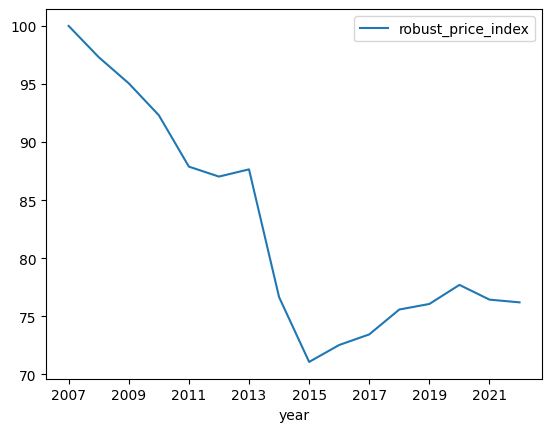

In [28]:
robust_results_df.plot.line(y="robust_price_index", x="year")

<Axes: xlabel='year'>

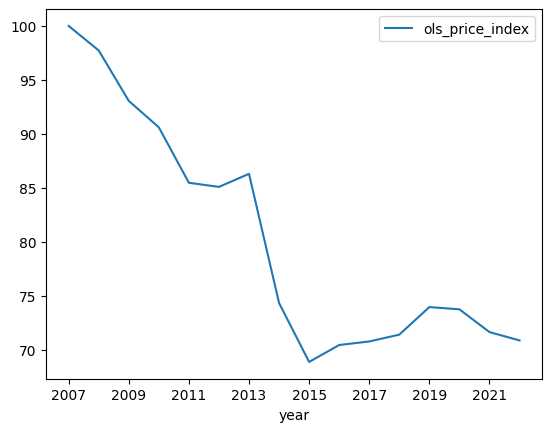

In [29]:
ordinary_results_df.plot.line(y="ols_price_index", x="year")

<Axes: xlabel='year'>

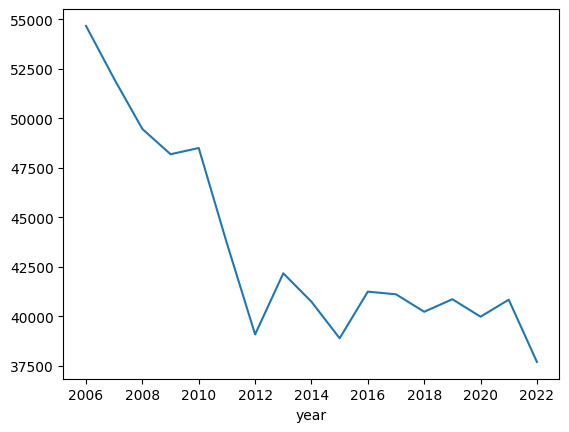

In [30]:
area_df.groupby(["year"])["unit_price"].apply(
    lambda x: np.exp(np.log(x).mean())
).plot.line()